In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import particle_filter
import embarrassingly_parallel
import prep_simulation_data
import history
import params
import pf_plots
from files_to_process import files_to_process

from scipy.special import logsumexp
from scipy import stats

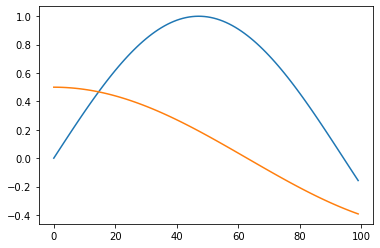

In [2]:
true_betas = np.ones((100, 2))
true_betas[:, 0] = np.sin(np.arange(100)/30)
true_betas[:, 1] = 0.5*np.cos(np.arange(100)/40)
plt.plot(true_betas)
plt.show()

X = np.random.randn(10000, 2)
bX = []
t = 0
r=0
times = []
for i in range(10000):
    bX.append(np.dot(true_betas[t, :], X[i, :]))
    times.append(t)
    r+=1
    if r == 100:
        t += 1
        r = 0
bX = np.array(bX)
times = np.array(times)
p = 1./(1+np.exp(bX))
y = np.random.binomial(1, p)


In [3]:
stationary_prior_mean = 0.
stationary_prior_std = 1.
stepsize=0.1

In [4]:
data = {}
D = 2
data['time_value'] = times
data['N'] = len(times)
data['b'] = stationary_prior_mean*np.ones((len(times), D))
data['B'] = stationary_prior_std
data['Tau_inv_std'] = stepsize
data['shards'] = 1
data['p'] = 2
data['X_matrix'] = X
data['Y'] = y
data['all_shard_unique_time_values'] = np.unique(times)


In [5]:
params={
            'N_batch'            : 1, 
            'shards'             : 1,
            'p_to_use'           : 1000,
            'particles_per_shard': 1000,
            's_num_before_comm'  : 1000,
            'randomize_shards'   : False,
            'model'              : 'probit_sin_wave',
            'sample_method'      : "importance",
            'data_type'          : 'simulated',
        }
class pf_params_synth_data():

    def __init__(self, params):
        #args.particles_per_shard, args.p_to_use, args.randomize_shards)
        M=1
        PART_NUM = 1000
        COMM_PER_SHARD_INTERVAL = 999999999#number of observations to process per shard before communication step
        self.params=params
        
    def get_params(self):
        return(self.params)
    
    def get_N_batch(self):
        return
    
    def get_shards(self):
        return self.params['shards']
    
    def get_particles_per_shard(self):
        return self.params['particles_per_shard']
    
    def get_model(self):
        return self.params['model']
    
    def get_sample_method(self):
        return self.params['sample_method']
    
    def get_data_type(self):
        return self.params['data_type']
params_obj = pf_params_synth_data(params)

In [6]:
pf = particle_filter.particle_filter(data, params_obj, 1, 1)

In [7]:
pf.update_data(data, 1)

In [8]:
import time
tic = time.time()
pf.run_particle_filter()
toc = time.time()

In [9]:
print(toc-tic)

36.574469804763794


In [10]:
def log_sigmoid(x):
    return -np.logaddexp(0, -x)

def loglik(b, X, y, sigma=None, method='classification', mult_obs=False):
    # if method == 'regression', sigma is the standard deviation of the residuals (assumed not learned)
    bX = np.dot(b, X.T)
    if mult_obs:
        ll = np.zeros(b.shape[0])
        
        for i in range(len(y)):
            # re-write, not very efficient
            if method == 'classification':
                if y[i] == 1:
                    ll += log_sigmoid(-1*bX[:, i])
                else:
                    assert y[i] == 0
                    ll += log_sigmoid(bX[:, i])
                    
            elif method == 'regression':
                ll += stats.norm.logpdf(y[i], bX[:, i], sigma)
            else:
                raise ValueError('{} is not implemented with multiple observations'.format(method))
    else:
        if method == 'classification':
            if y == 1:
                ll = log_sigmoid(-1*bX)
            else:
                assert y == 0
                ll = log_sigmoid(bX)
        elif method == 'regression':
            ll = stats.norm.logpdf(y, bX, sigma)
        else:
            raise ValueError('{} is not implemented'.format(method))
    return ll


def sinead_pf(X, y, times, num_particles, b_prior_mean=0., b_prior_std = 1., stepsize=0.05, 
        save_history=True, sigma=1., method='classification'):
    unique_times = np.unique(times)
    if len(unique_times) < len(times):
        repeat_obs = True
    else:
        repeat_obs = False
    # initialize particles
    N, D = X.shape
    T = len(unique_times)
    if save_history:
        history = np.zeros((T, D))
    particles = np.random.normal(b_prior_mean, b_prior_std, size=[num_particles, D])
    obs_inds = np.argwhere(times==unique_times[0]).squeeze()
    ll = loglik(particles, X[obs_inds, :], y[obs_inds], method=method, mult_obs=repeat_obs, sigma=sigma)
    log_weights = ll - logsumexp(ll)
    
    new_inds = np.random.choice(num_particles, num_particles, p=np.exp(log_weights))
    particles = particles[new_inds, :]
    if save_history:
        history[0, :] += np.mean(particles, axis=0)
    for j in range(1, len(unique_times)):
        timestepsize = stepsize * (unique_times[j]-unique_times[j-1])
        rescale_const = b_prior_std / np.sqrt(b_prior_std**2 + timestepsize**2)
        particles += np.random.normal(0, stepsize, size=[num_particles, D])
        particles = rescale_const * particles
        obs_inds = np.argwhere(times==unique_times[j]).squeeze()
        ll = loglik(particles, X[obs_inds, :], y[obs_inds], method=method, mult_obs=repeat_obs, sigma=sigma)
        log_weights = ll - logsumexp(ll)
        new_inds = np.random.choice(num_particles, num_particles, p=np.exp(log_weights))
        particles = particles[new_inds, :]
        if save_history:
            history[j, :] = np.mean(particles, axis=0)

    if save_history:
        return particles, history
    return particles
    

0.3635408878326416


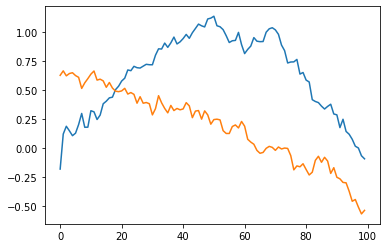

In [11]:
tic = time.time()
final_particles, history = sinead_pf(X, y, times, 1000)
toc = time.time()
print(toc-tic)
plt.plot(history)
plt.show()

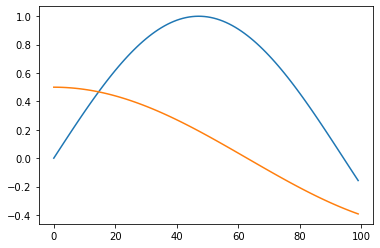

In [12]:
plt.plot(true_betas)
plt.show()